In [1]:
import pickle

import torch
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl
from copy import deepcopy
from tabulate import tabulate

# Download data from WANDB
And put them in dataframes

In [2]:
from utils import obtain_wandb_data

In [3]:
runs_list, runs_list_GAN, runs_list_SRs = obtain_wandb_data(["EMNIST"])

In [4]:
runs_list = runs_list[0]

In [5]:
runs_list=runs_list.sort_values("name")

We have trained with the SR methods using both 3 and 10 simulations for each training step; we will report below the results obtained with 10 samples.

Separate now the runs which use 3 and 10 n_generations (but we include GAN in both)

In [21]:
df_3 = runs_list[(runs_list["num_simulations_generator"]==3)  | (runs_list["loss"] == "cross_entropy")]
df_10 = runs_list[(runs_list["num_simulations_generator"]==10) | (runs_list["loss"] == "cross_entropy")]

The first run did not compute the RMSE values correctly. We therefore computed them subsequently; add them to the dataframe right now: 

In [7]:
names = ["camera_model_kernel_score_10", "camera_model_kernel_score_10_patched_5_8", "camera_model_energy_score_10_patched_5_8",
         "camera_model_energy_score_10_patched_7_14", "camera_model_energy_score_10", "camera_model_kernel_score_10_patched_7_14",
         "camera_model_GAN_800000"]
dicts = [{'rmse_val_mean': 0.06406807, 'rmse_val_std': 0.045899235},
         {'rmse_val_mean': 0.06944673, 'rmse_val_std': 0.04826797},
         {'rmse_val_mean': 0.06270825, 'rmse_val_std': 0.04553171},
         {'rmse_val_mean': 0.07040126, 'rmse_val_std': 0.04799262},
         {'rmse_val_mean': 0.0782916, 'rmse_val_std': 0.0482274},
         {'rmse_val_mean': 0.09903354, 'rmse_val_std': 0.058070697},
         {'rmse_val_mean': 0.25184682, 'rmse_val_std': 0.19277969}]

# loop over names and dicts
for name, dict in zip(names, dicts):
    row_index_1 = df_10["name"] == name 
    row_index_2 = df_3["name"] == name 
    # loop over dict keys
    for key in dict.keys():
        df_10.loc[row_index_1, key] = dict[key]
        df_3.loc[row_index_2, key] = dict[key]        

In [22]:
df_10

,name,ID,epochs,patch_size,patch_step,patched_sr,sample_seed,gen_opt_args,scoring_rule,hold_out_perc,...,dis_opt_args,max_norm_dis,max_norm_gen,num_simulations,dis_loss,dfake_std,dreal_std,dreal_mean,dis_grad,dfake_mean
12,camera_model_GAN_800000,u25w8avb,10000,NaN,NaN,NaN,42,"[0.0002, [0.5, 0.99]]",NaN,NaN,...,"[0.0002, [0.5, 0.99]]",0.01,0.01,800000.0,1.409826,0.0235,0.025258,0.496308,20.277802,0.506794
5,camera_model_energy_score_10,1tka5tp1,10000,NaN,NaN,False,42,"[0.0002, [0.5, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,camera_model_energy_score_10_patched_5_8,11wxayas,10000,8.0,5.0,True,42,"[0.0002, [0.5, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,camera_model_energy_score_10_patched_7_14,1q7dpoiq,10000,14.0,7.0,True,42,"[0.0002, [0.5, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,camera_model_kernel_score_10,v097tq54,10000,NaN,NaN,False,42,"[0.0002, [0.5, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,camera_model_kernel_score_10_patched_5_8,2bb5fc4j,10000,8.0,5.0,True,42,"[0.0002, [0.5, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,camera_model_kernel_score_10_patched_7_14,1g7nsdur,10000,14.0,7.0,True,42,"[0.0002, [0.5, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Print all metrics as Table
## However before doing this I need to compute the calibration metrics starting from the saved networks

This is because I added some metrics after training is done, so those compute by the training script are not enough



In [9]:
from glob import glob

In [10]:
root_folder = "../results/"

The following two cells generate the ground truth data

In [12]:
import importlib, yaml
task_name = "camera_model"

application = importlib.import_module("gatsbi.task_utils.%s" % task_name)

from argparse import Namespace as NSp

with open(join("..", "tasks", task_name, "defaults.yaml"), "r") as f:
    defaults = yaml.load(f, Loader=yaml.Loader)#
config = NSp(**defaults)

batch_size = min(1000, int(config.batch_size_perc * config.num_simulations))

Notice I use `few_samples=True` here that only loads a subset of data

In [13]:
path_to_data = "results/EMNIST_data"
prior = application.Prior(path_to_data=path_to_data, few_samples=True)
simulator = application.Simulator()

Loading EMNIST data...
Done.


In [14]:
from gatsbi.task_utils.camera_model import Generator
gen = Generator()

In [15]:
from gatsbi.utils import generate_test_set_for_calibration, compute_calibration_metrics

In [12]:
# n_post_samples = 100
task_name = "camera_model"
df_in = df_10

scoring_rule_list = ["energy_score", "kernel_score", "GATSBI"]
plot_labels = ["Energy Score", "Kernel Score", "GATSBI"]
patches_list = [None, [5,8], [7,14]]


Running the one below takes a lot of time. You can directly load the stored data with the cell immediately below

energy_score
1tka5tp1
Generating simulations from the generative network...


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


energy_score5_8
11wxayas
Generating simulations from the generative network...
energy_score7_14
1q7dpoiq
Generating simulations from the generative network...
kernel_score
v097tq54
Generating simulations from the generative network...
kernel_score5_8
2bb5fc4j
Generating simulations from the generative network...
kernel_score7_14
1g7nsdur
Generating simulations from the generative network...
GATSBI
u25w8avb
Generating simulations from the generative network...
CPU times: user 2h 28min 11s, sys: 23.8 s, total: 2h 28min 34s
Wall time: 2h 10min 10s


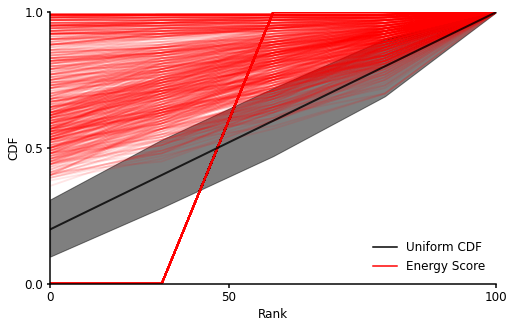

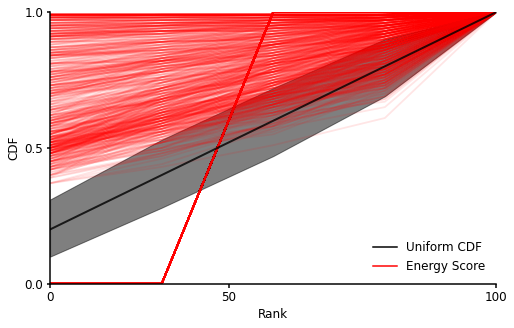

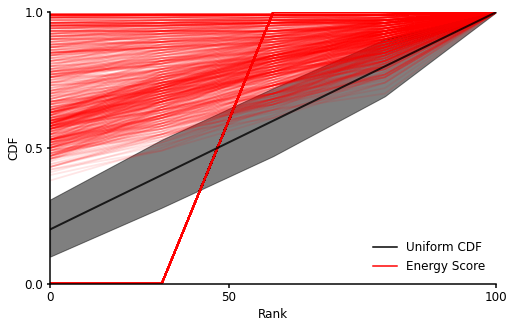

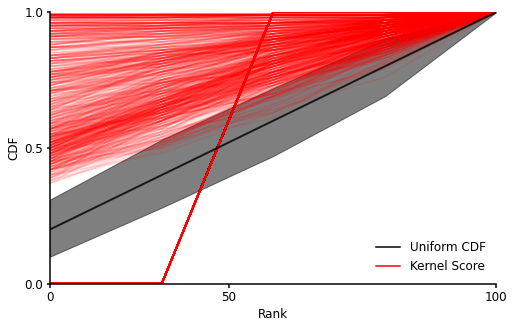

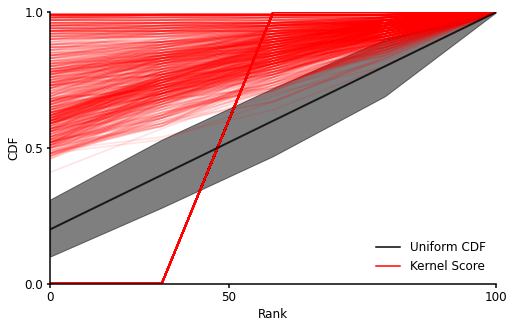

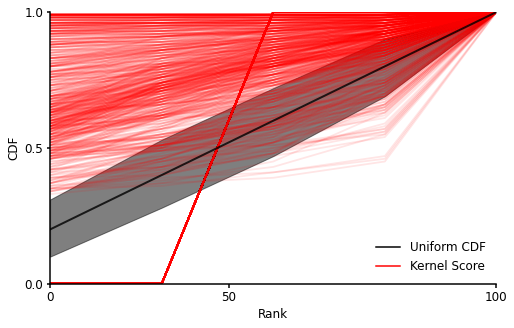

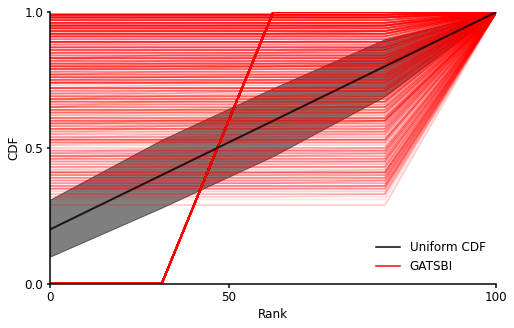

In [16]:
%%time

my_names_list = []

for scoring_rule, plot_label in zip(scoring_rule_list, plot_labels):
    for patch in patches_list:
        
        if scoring_rule == "GATSBI" and patch is not None:
            continue

        name = scoring_rule + ("" if patch is None else (str(patch[0]) + "_" + str(patch[1])))
        print(name)
        
        if scoring_rule != "GATSBI":
            # obtain the identifier
            df = df_in[df_in.scoring_rule == scoring_rule]
            if patch is None: 
                df = df[df.patched_sr == False]
            else:
                df = df[df.patched_sr== True]
                df = df[df.patch_size == patch[1]] 
        else:
            df = df_in[df_in.name == "camera_model_GAN_800000"]
            
        identifier = df["ID"].item()
        print(identifier)

        # obtain the path
        correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
        if len(correct_folder) == 0:
            print("No match")
            continue
        correct_folder = correct_folder[0]
        
        checkpoint_to_load = correct_folder +  "/files/checkpoint_models0.pt"
        
        # now should load the generative network for that folder:        
        chpt = torch.load(checkpoint_to_load, map_location=torch.device('cpu') )
        gen.load_state_dict(chpt["generator_state_dict"])

        test_theta_fake, test_theta = generate_test_set_for_calibration(prior, simulator, gen, n_test_samples=100,
                                                                        n_generator_simulations=1000,
                                                                        sample_seed=config.sample_seed,
                                                                        data_is_image=True)

        fig_filename = join("..", "results", task_name) + f"/{scoring_rule}_" + str(defaults["num_simulations"])

        res = compute_calibration_metrics(test_theta_fake, test_theta, sbc_lines=True,
                                          norm_rmse=task_name != "camera_model",
                                          sbc_lines_kwargs={"name": plot_label,
                                                      "filename": fig_filename + "_sbc_lines.pdf"},
                                    sbc_hist_kwargs={"filename": fig_filename + "_sbc_hist.pdf"})

        my_names_list.append(name)

        a_file = open(f"plotting_data/camera_model_calibration_metrics_{name}.pkl", "wb")
        pickle.dump(res, a_file)
        a_file.close()

        # wrap the generator so that it can generate multiple samples at once: 
        # gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=n_post_samples)                
        
        #break
    #break

In [23]:
res_list = []
name_list = []
for scoring_rule in scoring_rule_list:
    for patch in patches_list:
        
        if scoring_rule == "GATSBI" and patch is not None:
            continue
            
        name = scoring_rule + ("" if patch is None else (str(patch[0]) + "_" + str(patch[1])))
        name_for_df = task_name + "_" + scoring_rule + "_10" + ("" if patch is None else "_patched_" + (str(patch[0]) + "_" + str(patch[1])))

        name_list.append(name_for_df)
        
        a_file = open(f"plotting_data/camera_model_calibration_metrics_{name}.pkl", "rb")
        output = pickle.load(a_file)
        res_list.append(output)
        a_file.close()

In [24]:
import pandas as pd

In [25]:
# create dataframe from name and res_list 
res_df = pd.DataFrame(res_list, index=name_list)
# set the index to a column "name"
res_df["name"] = res_df.index
res_df

,cal_err_val_mean,r2_val_mean,rmse_val_mean,cal_err_val_std,r2_val_std,rmse_val_std,crps_val_mean,crps_val_std,sbc_lines,name
camera_model_energy_score_10,0.362570,-26.314490,0.069423,0.124498,235.339558,0.043858,0.052008,0.037107,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_energy_score_10
camera_model_energy_score_10_patched_5_8,0.367487,-2.910476,0.057854,0.116381,34.816194,0.041210,0.043818,0.032117,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_energy_score_10_patched_5_8
camera_model_energy_score_10_patched_7_14,0.370153,-10.809459,0.062779,0.116930,110.221620,0.041620,0.049714,0.033000,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_energy_score_10_patched_7_14
camera_model_kernel_score_10,0.328827,-3.478995,0.057852,0.150003,39.035666,0.041060,0.047879,0.032655,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_kernel_score_10
camera_model_kernel_score_10_patched_5_8,0.358884,-8.878045,0.062965,0.124224,81.427205,0.042705,0.060621,0.036367,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_kernel_score_10_patched_5_8
camera_model_kernel_score_10_patched_7_14,0.378622,-88.395800,0.085119,0.112859,735.488477,0.046252,0.068978,0.041170,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_kernel_score_10_patched_7_14
camera_model_GATSBI_10,0.502653,-2756.767829,0.251393,0.005519,58984.832662,0.193711,0.284114,0.262780,<wandb.sdk.data_types.image.Image object at 0x...,camera_model_GATSBI_10


In [26]:
# change name camera_model_GATSBI_10 to camera_model_GAN_800000
res_df["name"] = res_df["name"].replace("camera_model_GATSBI_10", "camera_model_GAN_800000")

In [27]:
# merge runs_list[["global_step", "_runtime"] with res_df
df_10 = df_10[["name", "global_step", "_runtime"]].merge(res_df, on="name")

In [28]:
df_10

,name,global_step,_runtime,cal_err_val_mean,r2_val_mean,rmse_val_mean,cal_err_val_std,r2_val_std,rmse_val_std,crps_val_mean,crps_val_std,sbc_lines
0,camera_model_GAN_800000,3600,45398,0.502653,-2756.767829,0.251393,0.005519,58984.832662,0.193711,0.284114,0.262780,<wandb.sdk.data_types.image.Image object at 0x...
1,camera_model_energy_score_10,4200,24555,0.362570,-26.314490,0.069423,0.124498,235.339558,0.043858,0.052008,0.037107,<wandb.sdk.data_types.image.Image object at 0x...
2,camera_model_energy_score_10_patched_5_8,4000,22633,0.367487,-2.910476,0.057854,0.116381,34.816194,0.041210,0.043818,0.032117,<wandb.sdk.data_types.image.Image object at 0x...
3,camera_model_energy_score_10_patched_7_14,3600,24033,0.370153,-10.809459,0.062779,0.116930,110.221620,0.041620,0.049714,0.033000,<wandb.sdk.data_types.image.Image object at 0x...
4,camera_model_kernel_score_10,3200,21862,0.328827,-3.478995,0.057852,0.150003,39.035666,0.041060,0.047879,0.032655,<wandb.sdk.data_types.image.Image object at 0x...
5,camera_model_kernel_score_10_patched_5_8,3200,22545,0.358884,-8.878045,0.062965,0.124224,81.427205,0.042705,0.060621,0.036367,<wandb.sdk.data_types.image.Image object at 0x...
6,camera_model_kernel_score_10_patched_7_14,3600,20605,0.378622,-88.395800,0.085119,0.112859,735.488477,0.046252,0.068978,0.041170,<wandb.sdk.data_types.image.Image object at 0x...


## Finally print the tables


In [32]:
def print_table(df, latex=False, file=None, tranpose=False):

    metrics = [['cal_err_val_std', 'cal_err_val_mean'], ['crps_val_std', 'crps_val_mean'],
               ['_runtime'], ['global_step']]
    metric_names = [r"Cal. Err. $ \downarrow $", r"CRPS $ \downarrow $", "Runtime (sec)", "Early stopping epoch"]
    # metrics = [['rmse_val_std', 'rmse_val_mean'], ['cal_err_val_std', 'cal_err_val_mean'],
    #                ['r2_val_std', 'r2_val_mean'], ['_runtime'], ['global_step']]
    # metric_names = [r"NRMSE $ \downarrow $", r"Cal. Err. $ \downarrow $", r"R$^2$ $ \uparrow $", "Runtime (sec)", "Early stopping epoch"]
    
    df_dict = df.to_dict("list")
    
    name_list = [""] + [name.replace("camera_model_", "").replace("_", " ").replace("score", "") for name in df_dict["name"]]
    
    all_lists = []
    all_lists.append(name_list)

    for name, metric in zip(metric_names, metrics): 
        inner_list = [name]    

        if len(metric) == 2:
            inner_list += [f"{df_dict[metric[1]][i]:.2f} $\pm$ {df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
        else:
            inner_list += [f"{df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
                
        all_lists.append(deepcopy(inner_list))

    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))
    
    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow"))
    else:
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow"))

In [33]:
print_table(df_10, file=f"tables/camera_model_all_metrics_n_gen={10}", latex=True, tranpose=True)

Print a Table with only the best performing method:

In [34]:
df_10_selected = df_10[df_10["name"].isin(["camera_model_GAN_800000", "camera_model_energy_score_10_patched_5_8", "camera_model_kernel_score_10_patched_5_8"])]
print_table(df_10_selected, file=f"tables/camera_model_best_methods_all_metrics_n_gen={10}", latex=True, tranpose=True)

# Images

Load the true data and the results with GATSBI and NPE

In [48]:
data = np.load(join("plotting_data/camera_samples.npz"))
theta_test,\
obs_test,\
gatsbi_samples,\
npe_samples = data["theta_test"],\
              data["obs_test"],\
              data["gatsbi_samples"],\
              data["npe_samples"]

In [49]:
theta_test.shape

(12, 1, 28, 28)

In [50]:
gatsbi_samples.shape

(12, 100, 1, 1, 28, 28)

## Original figure:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


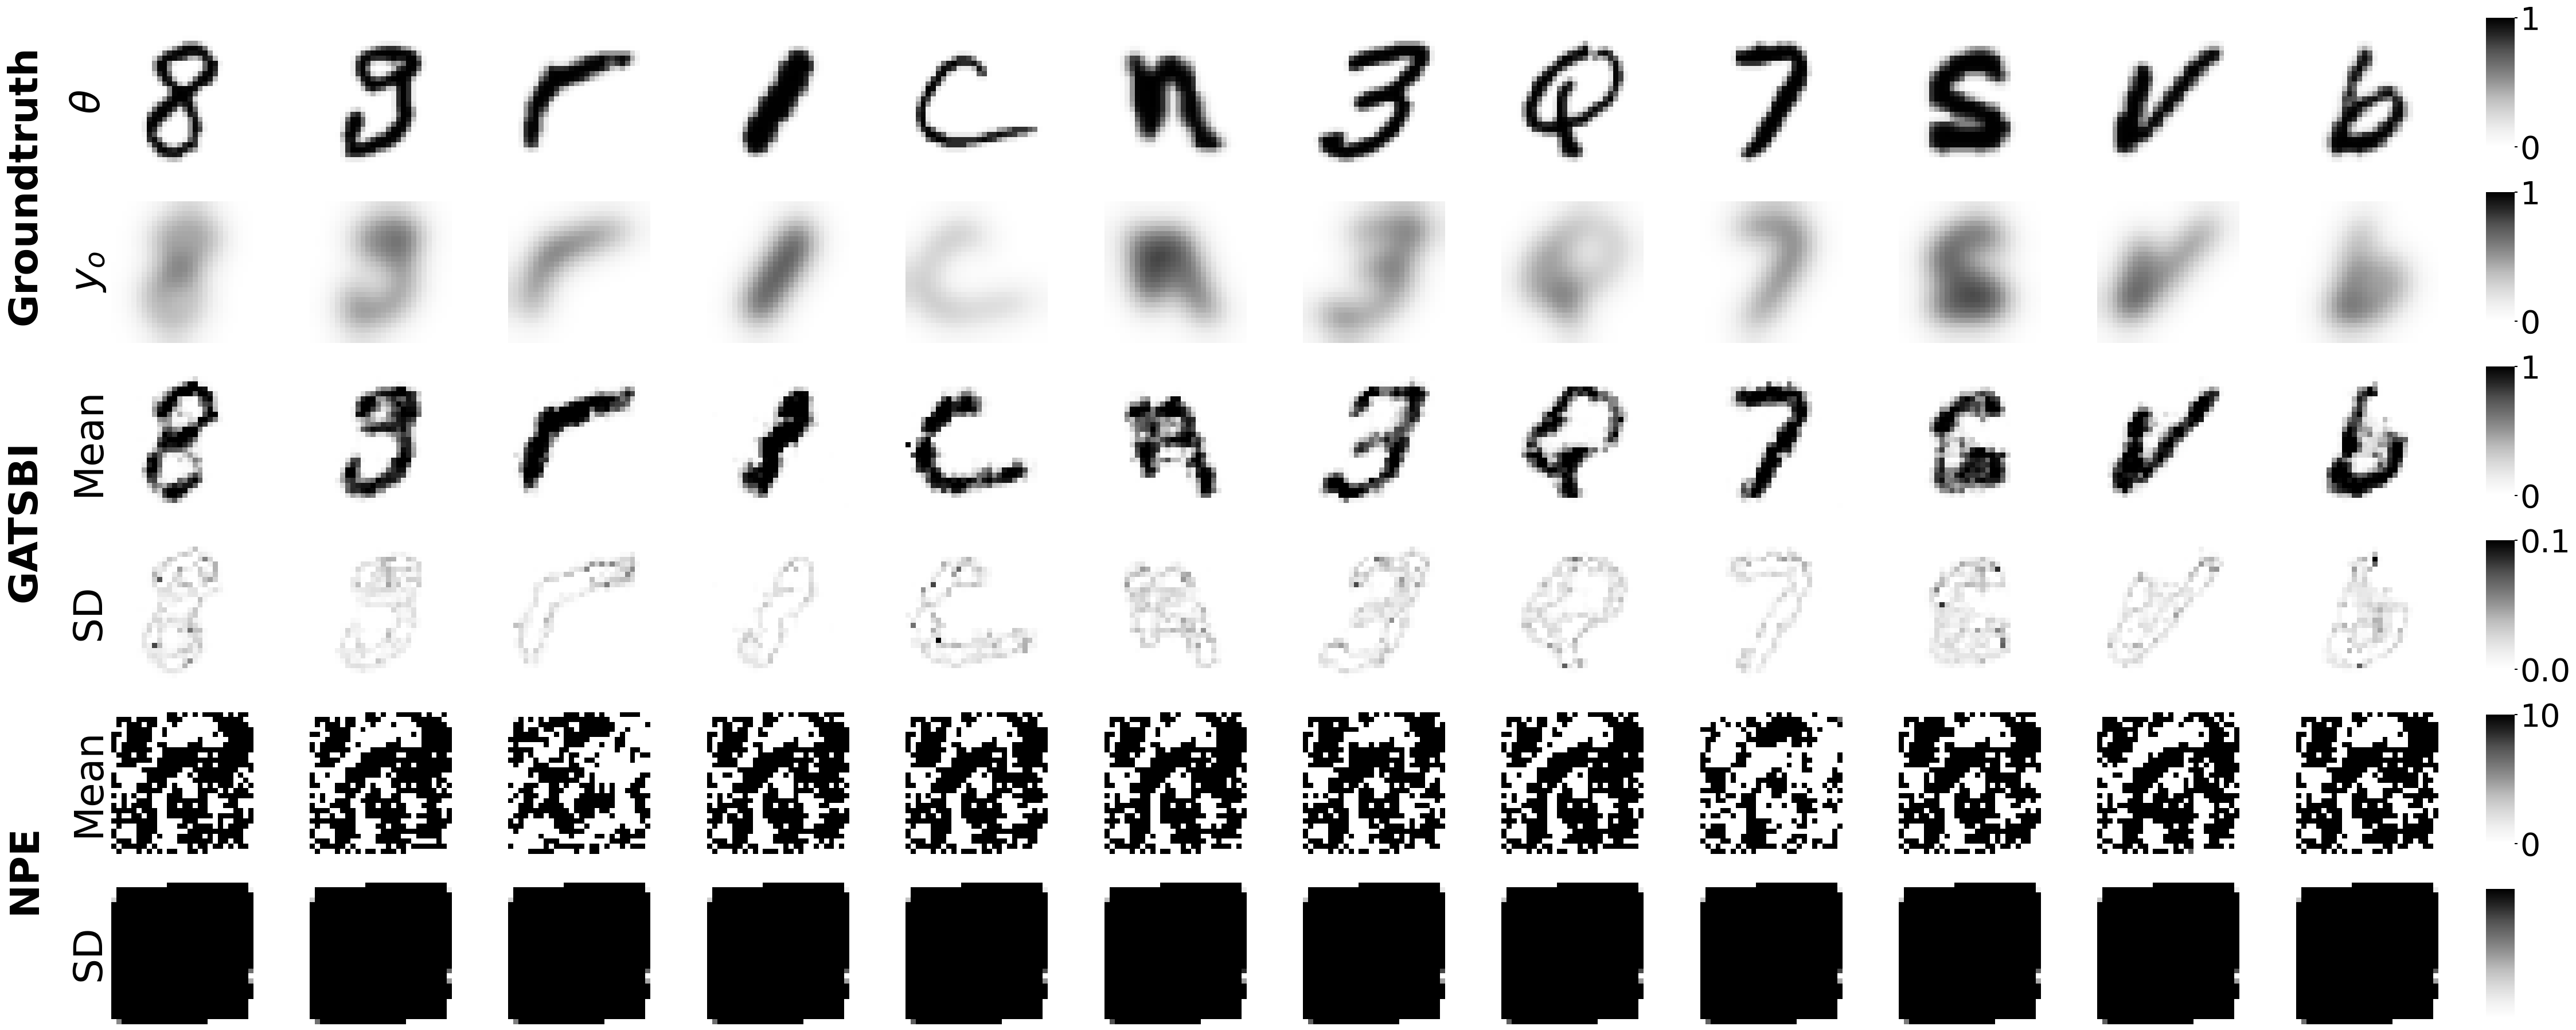

In [51]:
gt_colors = "Greys"
npe_colors = "Greys"
npe_colors_std = "Greys"

def add_cbar(cax, im, lim_min, lim_max):
    cbar = plt.colorbar(im, cax=cax, ticks=[lim_min, lim_max])
    cbar.ax.tick_params(labelsize=40)
    cbar.outline.set_visible(False)
    return cbar

def hide_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

with mpl.rc_context(fname='./matplotlibrc'):

    fig, axes = plt.subplots(6, 12, figsize=(50, 22.5))
    left_adjust = .96

    fig.subplots_adjust(right=.95, wspace=.1)
    caxs = []
    caxs.append(fig.add_axes([left_adjust, .79, .01, .1]))
    caxs.append(fig.add_axes([left_adjust, .655, .01, .1]))
    caxs.append(fig.add_axes([left_adjust, .52, .01, .1]))
    caxs.append(fig.add_axes([left_adjust, .385, .01, .1]))
    caxs.append(fig.add_axes([left_adjust, .25, .01, .1]))
    caxs.append(fig.add_axes([left_adjust, .115, .01, .1]))
    # 135
    # imshow settings
    fontname = "Arial"
    fontsize = 50
    origin = 'lower'
    mn_vmin = 0.
    mn_vmax = 1.

    std_vmin = 0.
    std_vmax = .1

    for i, ax in enumerate(axes.T):
        for j, (samp, tit) in enumerate(zip([theta_test, obs_test, [gatsbi_samples, npe_samples]],
                                            [r"$\theta$", r"$y_{o}$", "Mean"]
                                           )
                                       ):
            # Set ylabel
            if i == 0:
                ax[j].set_ylabel(tit, fontsize=fontsize, fontname=fontname)
                ax[4].set_ylabel("Mean", fontsize=fontsize, fontname=fontname)
                
                ax[3].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                ax[5].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                
            # Plot GT theta and obs
            if j < 2:
                im = ax[j].imshow((samp[i].squeeze()).T[::-1], 
                                  origin=origin,
                                  vmax=mn_vmax, 
                                  vmin=mn_vmin, 
                                  cmap=gt_colors)
                cbar = add_cbar(caxs[j], im, mn_vmin, mn_vmax)
                hide_ax(ax[j])
                
            # Plot NPE / GATSBI samples
            else:
                for k, (ss, mean_vmax, stdev_vmax) in enumerate(zip(samp, [1., 10.], [.1, 1000.])):
#                     mean = np.mean(npe_samples[i], 0).squeeze()
#                     std = np.std(npe_samples[i], 0).squeeze()
                    mean = np.mean(ss[i], 0).squeeze()
                    std = np.std(ss[i], 0).squeeze()
                    im = ax[j+ 2*k].imshow(mean.T[::-1], 
                                        origin=origin,
                                        vmax=mean_vmax,
                                        vmin=mn_vmin, 
                                        cmap=npe_colors)
                    cbar = add_cbar(caxs[j + 2*k], im, mn_vmin, mean_vmax)
                    hide_ax(ax[j + 2*k])

                    im = ax[j + 2*k + 1].imshow(std.T[::-1],
                                                vmax=stdev_vmax,
                                                vmin=std_vmin,
                                                origin=origin,
                                                cmap=npe_colors_std)
                    cbar = add_cbar(caxs[j + 2*k + 1], im, std_vmin, stdev_vmax)
                    hide_ax(ax[j + 2*k + 1])

    fig.text(0.095, .76, 
             "Groundtruth", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")

    fig.text(0.095, .5, 
             "GATSBI", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")
    
    fig.text(0.095, .23, 
             "NPE", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")

    ax = hide_ax(plt.gca())

    # plt.savefig("plots/Figure5.pdf")


## Create posterior samples for the other methods: 

In [52]:
from glob import glob

In [53]:
!mkdir plots/camera_model

mkdir: cannot create directory ‘plots/camera_model’: File exists


In [54]:
root_folder = "/data/localhost/pacchiar/GATSBI_extension_res/"

Define the generator for the task at hand:

In [55]:
import sys, os
sys.path.append(os.getcwd() + "/../")
from gatsbi.task_utils.camera_model import Generator
from gatsbi.networks import WrapGenMultipleSimulations

gen = Generator()

Transform the data

In [56]:
obs_test_tensor = torch.from_numpy(obs_test.astype(np.float32))

In [57]:
obs_test_tensor.shape

torch.Size([12, 1, 28, 28])

In [58]:
task_name = "camera_model"
df_in = df_10

scoring_rule_list = ["energy_score", "kernel_score"]
patches_list = [None, [5,8], [7,14]]
#scoring_rule_list = ["kernel_score"]
#patches_list = [[5,8]]

samples_list = []

for scoring_rule in scoring_rule_list:
    for patch in patches_list:

        # obtain the identifier
        df = df_in[df_in.scoring_rule == scoring_rule]
        if patch is None: 
            df = df[df.patched_sr == False]
        else:
            df = df[df.patched_sr== True]
            df = df[df.patch_size == patch[1]]         
            
        identifier = df["ID"].item()
        print(identifier)

        # obtain the path
        correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
        if len(correct_folder) == 0:
            print("No match")
            continue
        correct_folder = correct_folder[0]
        
        # now should load the generative network for that folder:        
        chpt = torch.load(correct_folder +  "/files/checkpoint_models0.pt",map_location=torch.device('cpu') )
        gen.load_state_dict(chpt["generator_state_dict"])

        # wrap the generator so that it can generate multiple samples at once: 
        gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=100)        
        
        # now feed the observations into the generator to obtain posterior samples: 
        samples_list.append(gen_wrapped(obs_test_tensor).unsqueeze(2).detach().numpy())  # add a dummy dimension to have same 
                

AttributeError: 'DataFrame' object has no attribute 'scoring_rule'

## Plot: best methods wrt GAN
Both Energy and Kernel Score with patch 5_8 perform well. Report those two in the main text
The best method is with kernel_score and patch 5_8

In [ ]:
main_samples = [gatsbi_samples, samples_list[1], samples_list[-2]]

In [ ]:
with mpl.rc_context(fname='./matplotlibrc'):

    fig, axes = plt.subplots(8, 12, figsize=(50, 22.5 * 4 / 3))
    left_adjust = .96

    fig.subplots_adjust(right=.95, wspace=.1)
    caxs = []
    height_caxs = .08
    
    caxs.append(fig.add_axes([left_adjust, .81, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .71, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .61, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .51, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .41, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .31, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .21, .01, height_caxs]))
    caxs.append(fig.add_axes([left_adjust, .11, .01, height_caxs]))

    # 135
    # imshow settings
    fontname = "Arial"
    fontsize = 50
    origin = 'lower'
    mn_vmin = 0.
    mn_vmax = 1.

    std_vmin = 0.
    std_vmax = .1

    #for i, ax in enumerate(axes.T):
    for i, ax in enumerate(axes.T):
        for j, (samp, tit) in enumerate(zip([theta_test, obs_test, main_samples],
                                            [r"$\theta$", r"$y_{o}$", "Mean", "Mean"]
                                           )
                                       ):
            # Set ylabel
            if i == 0:
                ax[j].set_ylabel(tit, fontsize=fontsize, fontname=fontname)
                ax[4].set_ylabel("Mean", fontsize=fontsize, fontname=fontname)
                ax[6].set_ylabel("Mean", fontsize=fontsize, fontname=fontname)
                
                ax[3].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                ax[5].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                ax[7].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                
            # Plot GT theta and obs
            if j < 2:
                im = ax[j].imshow((samp[i].squeeze()).T[::-1], 
                                  origin=origin,
                                  vmax=mn_vmax, 
                                  vmin=mn_vmin, 
                                  cmap=gt_colors)
                cbar = add_cbar(caxs[j], im, mn_vmin, mn_vmax)
                hide_ax(ax[j])
                
            # Plot NPE / GATSBI samples
            else:
                for k, (ss, mean_vmax, stdev_vmax) in enumerate(zip(samp, [1., 1., 1.], [.1, .5, .5])):
#                     mean = np.mean(npe_samples[i], 0).squeeze()
#                     std = np.std(npe_samples[i], 0).squeeze()
                    mean = np.mean(ss[i], 0).squeeze()
                    std = np.std(ss[i], 0).squeeze()
                    #print("method {}, max std {}".format(k,std.max()))
                    #if std.max()>0.4:
                    #    print(k)
                    im = ax[j+ 2*k].imshow(mean.T[::-1], 
                                        origin=origin,
                                        vmax=mean_vmax,
                                        vmin=mn_vmin, 
                                        cmap=npe_colors)
                    cbar = add_cbar(caxs[j + 2*k], im, mn_vmin, mean_vmax)
                    hide_ax(ax[j + 2*k])

                    im = ax[j + 2*k + 1].imshow(std.T[::-1],
                                                vmax=stdev_vmax,
                                                vmin=std_vmin,
                                                origin=origin,
                                                cmap=npe_colors_std)
                    cbar = add_cbar(caxs[j + 2*k + 1], im, std_vmin, stdev_vmax)
                    hide_ax(ax[j + 2*k + 1])

    fig.text(0.095, .8, 
             "Groundtruth", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")

    fig.text(0.095, .6, 
             "GAN", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")
    
    fig.text(0.095, .4, 
             "Energy Score", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")

    fig.text(0.095, .2, 
             "Kernel Score", 
             rotation='vertical', 
             va='center', 
             fontsize=fontsize,
             fontname=fontname,
             fontweight="bold")

    #ax = hide_ax(plt.gca())  # that is useless

    plt.savefig("plots/camera_model/camera_model_best_methods.pdf")

Now create all plots at once

In [ ]:
samples_list_total = [gatsbi_samples] + samples_list

In [ ]:
assert len(samples_list_total) == 7

with mpl.rc_context(fname='./matplotlibrc'):

    fig, axes = plt.subplots((1 + len(samples_list_total)) * 2, 12, figsize=(50, 22.5 * (1 + len(samples_list_total)) / 3))
    left_adjust = .96

    fig.subplots_adjust(right=.95, wspace=.1)

    height_caxs = .04
    start_caxs_pos = 0.11
    factor_caxs_pos = 0.049
    caxs = []
    for i in range(16):
        caxs.append(fig.add_axes([left_adjust, start_caxs_pos + i *factor_caxs_pos, .01, height_caxs]))
    caxs.reverse()
        
    # 135
    # imshow settings
    fontname = "Arial"
    fontsize = 50
    origin = 'lower'
    mn_vmin = 0.
    mn_vmax = 1.

    std_vmin = 0.
    std_vmax = .1

    #for i, ax in enumerate(axes.T):
    for i, ax in enumerate(axes.T):
        for j, (samp, tit) in enumerate(zip([theta_test, obs_test, samples_list_total],
                                            [r"$\theta$", r"$y_{o}$", "Mean"]
                                           )
                                       ):
            # Set ylabel
            if i == 0:
                ax[j].set_ylabel(tit, fontsize=fontsize, fontname=fontname)
                ax[3].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                
                for kk in range(2, 8):
                    ax[2*kk].set_ylabel("Mean", fontsize=fontsize, fontname=fontname)
                    ax[2*kk+1].set_ylabel("SD", fontsize=fontsize, fontname=fontname)
                
            # Plot GT theta and obs
            if j < 2:
                im = ax[j].imshow((samp[i].squeeze()).T[::-1], 
                                  origin=origin,
                                  vmax=mn_vmax, 
                                  vmin=mn_vmin, 
                                  cmap=gt_colors)
                cbar = add_cbar(caxs[j], im, mn_vmin, mn_vmax)
                hide_ax(ax[j])
                
            # Plot NPE / GATSBI samples
            else:
                for k, (ss, mean_vmax, stdev_vmax) in enumerate(zip(samp, [1.] * len(samp), [.1] + [.5]* (len(samp)-1))):
#                     mean = np.mean(npe_samples[i], 0).squeeze()
#                     std = np.std(npe_samples[i], 0).squeeze()
                    mean = np.mean(ss[i], 0).squeeze()
                    std = np.std(ss[i], 0).squeeze()
                    #print("method {}, max std {}".format(k,std.max()))
                    #if std.max()>0.4:
                    #    print(k, std.max())
                    im = ax[j+ 2*k].imshow(mean.T[::-1], 
                                        origin=origin,
                                        vmax=mean_vmax,
                                        vmin=mn_vmin, 
                                        cmap=npe_colors)
                    cbar = add_cbar(caxs[j + 2*k], im, mn_vmin, mean_vmax)
                    hide_ax(ax[j + 2*k])

                    im = ax[j + 2*k + 1].imshow(std.T[::-1],
                                                vmax=stdev_vmax,
                                                vmin=std_vmin,
                                                origin=origin,
                                                cmap=npe_colors_std)
                    cbar = add_cbar(caxs[j + 2*k + 1], im, std_vmin, stdev_vmax)
                    hide_ax(ax[j + 2*k + 1])

                    
    names = ["Groundtruth", "GAN", "Energy", "Energy 5,8", "Energy 7,14", "Kernel", "Kernel 5,8", "Kernel 7,14"]
    positions = [.835,.74,.65, .55, .45, .35, .25625, .15]
    for pos, name in zip(positions, names):
        fig.text(0.095, pos, 
                 name, 
                 rotation='vertical', 
                 va='center', 
                 fontsize=fontsize,
                 fontname=fontname,
                 fontweight="bold")

    plt.savefig("plots/camera_model/camera_model_all_methods.pdf")